**Brian Blaylock**  
**April 1, 2019** _This is no joke_

# Fractions Skill Score (FSS)
## HRRR-GLM Verification

> Roberts, N.M. and H.W. Lean, 2008: Scale-Selective Verification of Rainfall Accumulations from High-Resolution Forecasts of Convective Events. Mon. Wea. Rev., 136, 78–97, https://doi.org/10.1175/2007MWR2123.1

- Be sure to check that the FSS is better than the base rate, which is FSS_random (FSS from a random forecast).
- Check FSS_uniform, which is FSS for neighborhood at the grid scale (n=1) or FSS_uniform = 0.5+baseRate/2. (halfway between random forecast and perfect skill).

In [1]:
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import numpy as np
import scipy.ndimage as ndimage
import os
import multiprocessing

import sys
sys.path.append('/uufs/chpc.utah.edu/common/home/u0553130/pyBKB_v3')

from BB_HRRR.HRRR_Pando import get_hrrr_all_valid, \
                               get_hrrr_latlon, \
                               get_hrrr_variable


from BB_HRRR.GLM_and_HRRR.GLM_events_HRRR import get_GLM_HRRR_contingency_stats,\
                                                 m, Hlat, Hlon, domains


from BB_GOES.get_GLM import get_GLM_file_nearesttime, \
                            accumulate_GLM_FAST, \
                            bin_GLM_on_HRRR_grid
from BB_maps.my_basemap import draw_HRRR_map, \
                               draw_centermap
from BB_HRRR.HRRR_paths import get_domains
from BB_wx_calcs.binary_events import *

Create HRRR map.
Forecasts [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
Generate domains and masks.


In [160]:
domains['East']['mask']

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

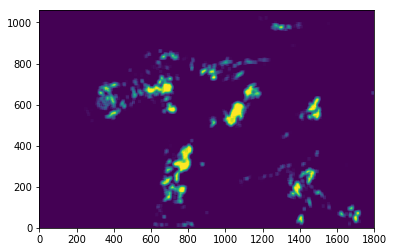

In [197]:
mask = domains['HRRR']['mask']
masked_obs_fracs = np.ma.array(obs_fracs, mask=mask)
masked_fxx_fracs = np.ma.array([np.ma.array(f, mask=mask) for f in fxx_fracs])
plt.pcolormesh(masked_fxx_fracs[16])

In [198]:
MSE = np.mean((masked_obs_fracs - masked_fxx_fracs)**2, axis=(1,2))
MSE_ref = np.mean(masked_obs_fracs**2) + np.mean(masked_fxx_fracs**2, axis=(1,2))
FSS = 1 - (MSE/MSE_ref)

(0, 1)

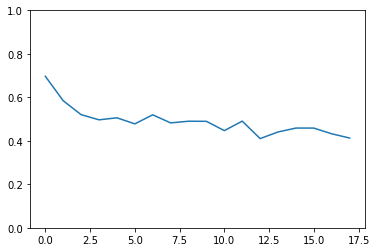

In [201]:
plt.plot(FSS)
plt.ylim([0,1])

In [2]:
DATE = datetime(2018, 5, 14, 22) # Mallard Fire
#DATE = datetime(2018, 7, 5, 23) # Lake Christine
#DATE = datetime(2018, 7, 17, 6) # July Storm
#DATE = datetime(2018, 7, 27, 0) # Missing GLM data

In [3]:
a = get_GLM_HRRR_contingency_stats(DATE)

(1/7) Get GLM Events.
-->> Accumulate GLM FAST MP: 70.0%
Got 180 of 180 expected files.
Total Events: 2,338,503
(2/7) Get HRRR Data.
-->> Accumulate GLM FAST MP: 40.0%(3/7) Filter GLM.
(4/7) Put GLM on HRRR grid.
In-HRRR Events: 1,071,362
      1,071,362 events in HRRR
         66,134 events in West
        325,528 events in Central
        301,341 events in East
          7,965 events in Utah
(5/7) Bloat GLM data with spatial filter.
(6/7) Generate binary grids.
(7/7) Compute contingency table for each subdomain.
    Stats for HRRR
    Stats for West
    Stats for Central
    Stats for East
    Stats for Utah
(FIN)


In [4]:
obs_binary = a['Observed Binary']
fxx_binary = a['Forecast Binary'][15]

In [69]:
import multiprocessing

In [92]:
def FSS_MP(inputs):
    """ FSS Multiprocessing for each of the forecast fields"""
    n, fxx_b, window = inputs
    print('Working on (%s): with window %s' % (n, window))
    return ndimage.generic_filter(fxx_b, fraction, size=window, mode='constant', cval=0)
    print('Finished on (%s): with window %s' % (n, window))

In [83]:
fxx_binary = np.array(a['Forecast Binary'], dtype=float)

In [87]:
cores = np.minimum(len(fxx_binary), multiprocessing.cpu_count()-2)

In [89]:
fxx_list = [[n, fxx_b, window] for n, fxx_b in enumerate(fxx_binary)]

In [91]:
with multiprocessing.Pool(cores) as p:
            fxx_fracs = p.map(FSS_MP, fxx_list)
            p.close()
            p.join()

Working on (0): with window 17
Working on (1): with window 17
Working on (2): with window 17
Working on (3): with window 17
Working on (4): with window 17
Working on (5): with window 17
Working on (6): with window 17
Working on (7): with window 17
Working on (8): with window 17
Working on (9): with window 17
Working on (10): with window 17
Working on (11): with window 17
Working on (12): with window 17
Working on (13): with window 17
Working on (14): with window 17
Working on (15): with window 17
Working on (16): with window 17
Working on (17): with window 17


In [106]:
obs_fracs = ndimage.generic_filter(np.array(a['Observed Binary'], dtype=float), fraction, size=window, mode='constant', cval=0)

In [113]:
np.shape(obs_fracs-fxx_fracs)

(18, 1059, 1799)

In [118]:
this_diff = (obs_fracs-fxx_fracs)**2
that_diff = np.array([obs_fracs-f for f in fxx_fracs])**2

In [130]:
MSE = np.mean((obs_fracs - fxx_fracs)**2, axis=(1,2))

In [148]:
MSE_ref = (np.sum(obs_fracs**2) + np.sum(fxx_fracs**2, axis=(1,2)))/np.size(obs_fracs)

In [149]:
MSE_ref2 = np.mean(obs_fracs**2) + np.mean(fxx_fracs**2, axis=(1,2))

(0, 1)

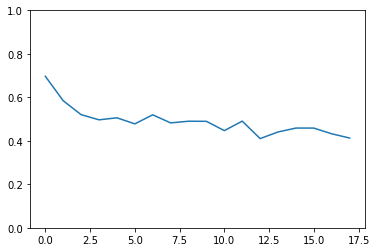

In [156]:
plt.plot(1- MSE/MSE_ref)
plt.ylim([0,1])

In [143]:
aa = [1,2,3,4,5,6, 100,1,2,3,4,5,6,7,8,9,0]
bb = [5,6,7,8,9,10, 201,3,4,5,6,7,8,9,0,1,0]
(np.sum(aa)+np.sum(bb))/len(aa), np.mean(aa) + np.mean(bb)

(26.764705882352942, 26.764705882352942)

In [68]:
a.keys()

dict_keys(['Number Events', 'table', 'Observed Binary', 'Forecast Binary', 'Number GLM Files', 'Number Expected Files', 'DATETIME'])

In [5]:
radius = 8

obs_binary = np.array(obs_binary, dtype=float)
fxx_binary = np.array(fxx_binary, dtype=float)

Text(0.5,0.98,'2018-05-14 22:00:00')

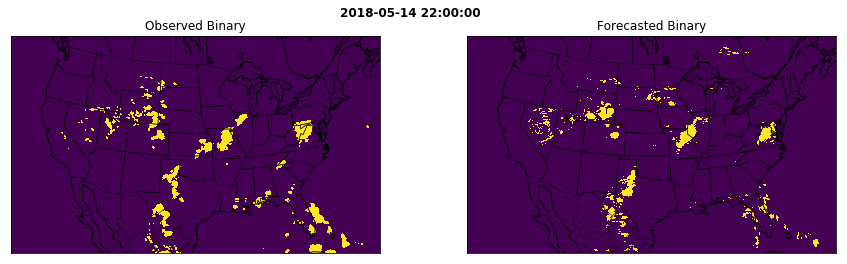

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,4))
plt.sca(ax1)
m.drawcoastlines()
m.drawstates()
m.drawcountries()
m.pcolormesh(Hlon, Hlat, obs_binary, latlon=True)
plt.title('Observed Binary')

plt.sca(ax2)
m.drawcoastlines()
m.drawstates()
m.drawcountries()
m.pcolormesh(Hlon, Hlat, fxx_binary, latlon=True)
plt.title('Forecasted Binary')

plt.suptitle(DATE, fontweight='semibold')

Text(0.5,0.98,'2018-05-14 22:00:00\nRadius=8\nFSS=0.44')

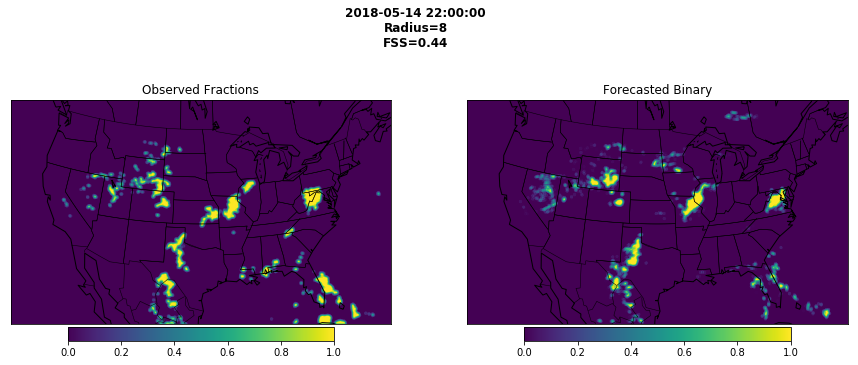

In [13]:
radius = 8
FSS_r8 = fractions_skill_score(obs_binary, fxx_binary, radius=radius)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6))
plt.sca(ax1)
m.drawcoastlines()
m.drawstates()
m.drawcountries()
m.pcolormesh(Hlon, Hlat, FSS_r8['Observed Fraction'], vmax=1, vmin=0, latlon=True)
plt.colorbar(orientation='horizontal', shrink=.7, pad=.01)
plt.title('Observed Fractions')

plt.sca(ax2)
m.drawcoastlines()
m.drawstates()
m.drawcountries()
m.pcolormesh(Hlon, Hlat, FSS_r8['Forecast Fraction'], vmax=1, vmin=0, latlon=True)
plt.colorbar(orientation='horizontal', shrink=.7, pad=.01)
plt.title('Forecasted Binary')

plt.suptitle("%s\nRadius=%s\nFSS=%.2f" % (DATE, 8, FSS_r8['FSS']), fontweight='semibold')

In [58]:
# [1, 3, 9, 27, 81]

#FSS = {}
for r in [60]:
    timer = datetime.now()
    FSS['r%02d' % r] = fractions_skill_score(obs_binary, fxx_binary, radius=r)
    print(datetime.now()-timer)

Convert Boolean field to float (1=True, 0=False)
Generate fractions for the neighborhood
Footprint radius: 60 grid boxes
Compute fractions skill score
0:03:01.902942


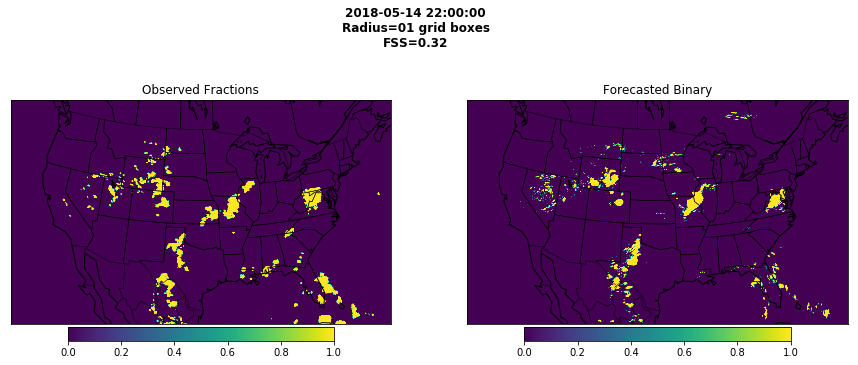

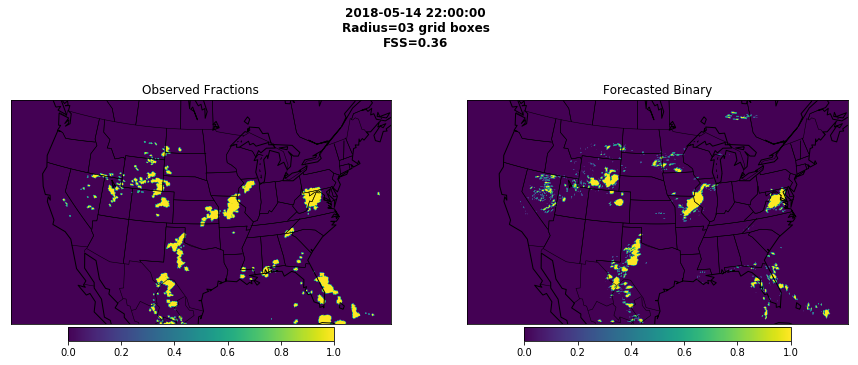

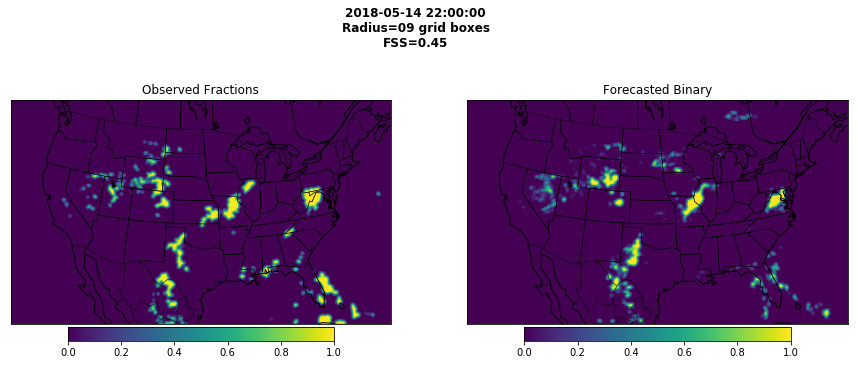

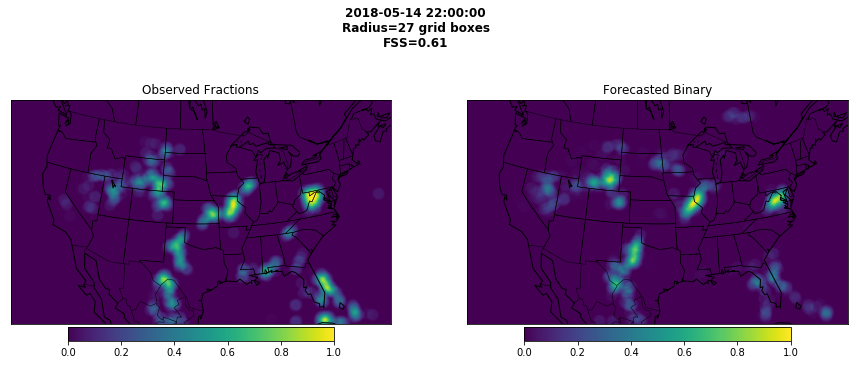

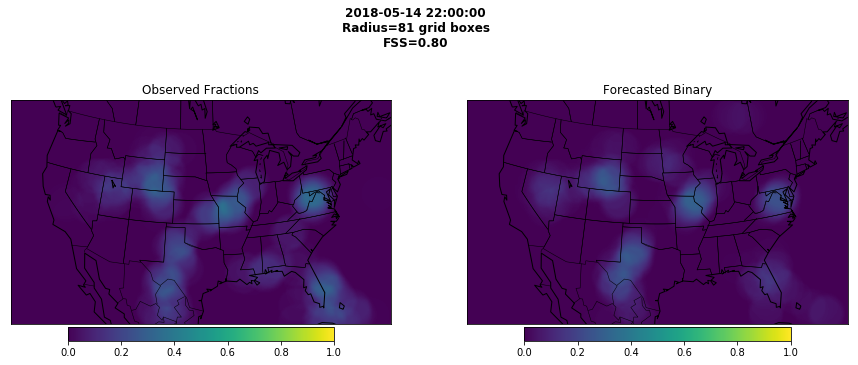

In [27]:
for i in FSS:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6))
    plt.sca(ax1)
    m.drawcoastlines()
    m.drawstates()
    m.drawcountries()
    m.pcolormesh(Hlon, Hlat, FSS[i]['Observed Fraction'], vmax=1, vmin=0, latlon=True)
    plt.colorbar(orientation='horizontal', shrink=.7, pad=.01)
    plt.title('Observed Fractions')

    plt.sca(ax2)
    m.drawcoastlines()
    m.drawstates()
    m.drawcountries()
    m.pcolormesh(Hlon, Hlat, FSS[i]['Forecast Fraction'], vmax=1, vmin=0, latlon=True)
    plt.colorbar(orientation='horizontal', shrink=.7, pad=.01)
    plt.title('Forecasted Binary')

    plt.suptitle("%s\nRadius=%s grid boxes\nFSS=%.2f" % (DATE, i[1:], FSS[i]['FSS']), fontweight='semibold')

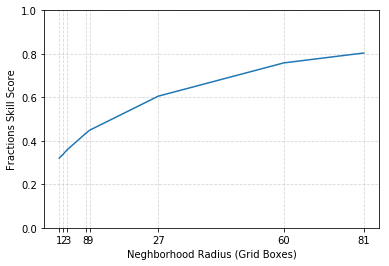

In [59]:
n = [int(i[1:]) for i in FSS]
fss_values = [FSS[i]['FSS'] for i in FSS]

order = np.argsort(n)
new_n = np.array(n)[order]
new_fss = np.array(fss_values)[order]

plt.plot(new_n, new_fss)
plt.xlabel('Neghborhood Radius (Grid Boxes)')
plt.ylabel('Fractions Skill Score')
plt.ylim([0,1])

plt.xticks(new_n)
plt.grid(linestyle='--', alpha=.5)

In [42]:
order = np.argsort(n)
new_n = np.array(n)[order]
new_fss = np.array(fss_values)[order]

In [41]:
new_n

array([ 1,  2,  3,  9, 27, 81])